Are you curious about fertilizer use in developing economies? The growth of Chinese steel exports? American chocolate consumption? Which parts of the world still use typewriters? You'll find all of that and more here. This dataset covers import and export volumes for 5,000 commodities across most countries on Earth over the last 30 years.

The sample contains data for Russian Federation, Ukraine and Belarus

Columns:
 - `country_or_area`: Country name of record
 - `year`: Year in which the trade has taken place
 - `comm_code`: Per the World Customs Organization: The Harmonized Commodity Description and Coding System generally referred to as "Harmonized System" or simply "HS" is a multipurpose international product nomenclature developed by the World Customs Organization (WCO). It comprises about 5,000 commodity groups; each identified by a six digit code, arranged in a legal and logical structure and is supported by well-defined rules to achieve uniform classification. For more, see [here](http://www.wcoomd.org/en/topics/nomenclature/overview/what-is-the-harmonized-system.aspx)
 - `commodity`: The description of a particular commodity code, i.e. "Horses, live pure-bred breeding"
 - `flow`: Flow of trade i.e. Export, Import
 - `trade_usd`: Value of the trade in USD
 - `weight_kg`: Weight of the commodity in Kilograms
 - `quantity_name`: A description of the quantity measurement type given the type of item (i.e. Number of Items, Weight in Kilograms, etc.)
 - `quantity`: Count of the quantity of a given item based on the Quantity Name
 - `category`: Category to identify commodity

In [1]:
import pandas
import seaborn
import random
from matplotlib import pyplot, ticker

In [2]:
def fetch_countries_data() -> [pandas.DataFrame]:
    commodity_trade_data = pandas.read_csv(
        'commodity_trade_statistics_data.csv',
        low_memory=False
    )

    countries = []

    for country in ['Russian Federation', 'Belarus', 'Ukraine']:
        data: pandas.DataFrame = commodity_trade_data.loc[
            (commodity_trade_data['country_or_area'] == country)
        ].convert_dtypes()#.drop('country_or_area', axis=1)

        countries.append(data)

    return countries

def get_random_color() -> tuple:
    return (
        random.random(),
        random.random(),
        random.random()
    )

russian_data, belarus_data, ukraine_data, *_ = fetch_countries_data()

## Import

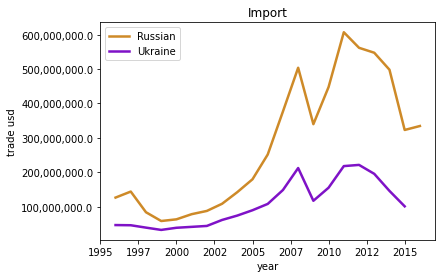

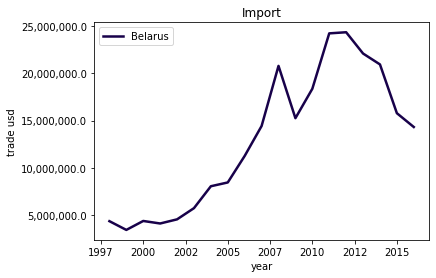

In [3]:
def build_trade_graph(
        countries_data: [pandas.DataFrame],
        keys: [str]
):
    _, axes = pyplot.subplots()
    axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,}'.format(x)))
    axes.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: int(x)))
    axes.set_title('Import')
    axes.set_ylabel('trade usd')

    for country_data in countries_data:
        seaborn.lineplot(
            x="year",
            y="trade_usd",
            ci=None,
            color=get_random_color(),
            linewidth=2.5,
            data=country_data.loc[:, ['year', 'trade_usd']],
            ax=axes
        )
    axes.legend(keys)

build_trade_graph(
    countries_data=[
        russian_data.loc[russian_data['flow'] == 'Import'],
        ukraine_data.loc[ukraine_data['flow'] == 'Import']
    ],
    keys=['Russian', 'Ukraine'])

build_trade_graph(
    countries_data=[
        belarus_data.loc[belarus_data['flow'] == 'Import']
    ],
    keys=['Belarus'])

pyplot.show()

На графиках можно наблюдать сокращение импорта товаров в промежутке с 2007 по 2009 и второй с 2012 по 2014.

- Сокращение с 2007 по 2009 можно объяснить мировым кризисом.
- Сокращение с 2012 по 2014 может быть связано с сокращением поставок нефти и нефтепродуктов на мировом рынке (из разных источников можно сделать вывод, что товары нефтепродуктов, в этот период сократились на 75%)

## Weight and quantity

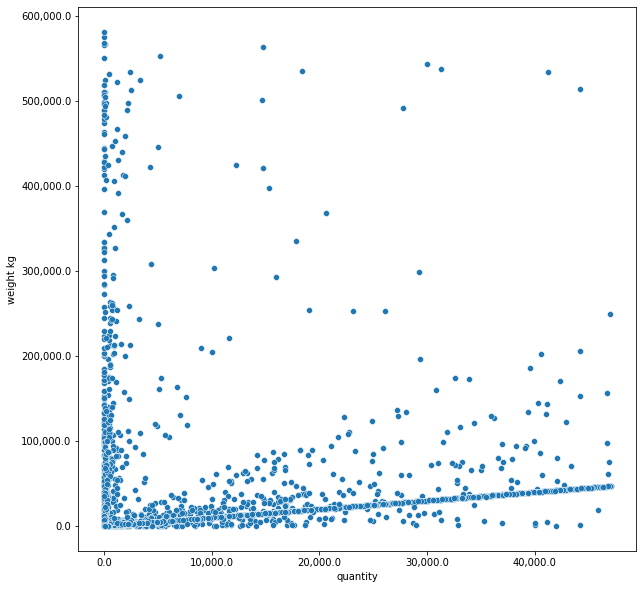

In [4]:
def get_weight_quantity_data_frame(country_data_frame: pandas.DataFrame) -> pandas.DataFrame:
    weight_quantity_data = country_data_frame.loc[:, ['quantity', 'weight_kg']]
    weight_quantity_data = weight_quantity_data.dropna()
    weight_quantity_data = weight_quantity_data.loc[(weight_quantity_data['weight_kg'] > 0)
                                                    & (weight_quantity_data['quantity'] > 0)]

    quantile = weight_quantity_data['weight_kg'].quantile(.6)
    weight_quantity_data = weight_quantity_data.loc[weight_quantity_data['weight_kg'] < quantile]

    quantile = weight_quantity_data['quantity'].quantile(.6)
    weight_quantity_data = weight_quantity_data.loc[weight_quantity_data['quantity'] < quantile]

    return weight_quantity_data

def build_weight_graph(countries_data: [pandas.DataFrame]):
    _, axes = pyplot.subplots(figsize=(10, 10))

    axes.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,}'.format(x)))
    axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,}'.format(x)))
    axes.set_ylabel('weight kg')

    seaborn.scatterplot(
        x="quantity",
        y="weight_kg",
        data=countries_data,
        ax=axes
    )

weight_quantity_data_frame = get_weight_quantity_data_frame(
    country_data_frame=russian_data
).set_index('weight_kg')

build_weight_graph(weight_quantity_data_frame)
pyplot.show()

Россия покупает много  товаров и они мало весят или покупают мало, но товары тяжелые.

## Category and quantity

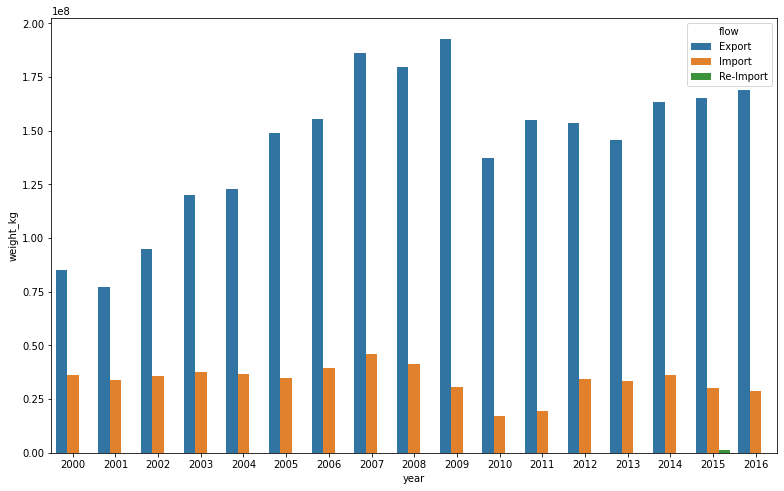

In [5]:
def get_flow_year_data_frame(data_frame: pandas.DataFrame) -> pandas.DataFrame:
    return data_frame.loc[data_frame['year'] >= 2000]

def build_flow_year_graph(data_frame: pandas.DataFrame):
    _, axes = pyplot.subplots(figsize=(13, 8))

    seaborn.barplot(
        x="year",
        y="weight_kg",
        hue="flow",
        ci=None,
        data=data_frame,
        ax=axes)

build_flow_year_graph(
    data_frame=get_flow_year_data_frame(russian_data)
)
pyplot.show()

У России продаж товаров на мировом рынке больше чем закупок.

## Trade

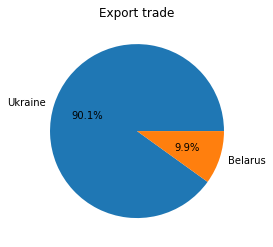

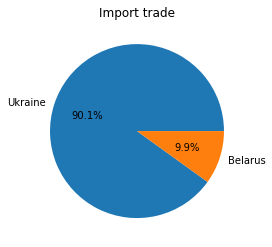

In [6]:
def build_trade_graph(
        data_frames: [pandas.DataFrame],
        labels: [str],
        filter: str
):
    _, axes = pyplot.subplots()

    sizes = []
    for data in data_frames:
        filter_data = data.loc[(data['flow'] == filter)
                                & (data['year'] >= 1997)
                                & (data['year'] <= 2015)]
        sizes.append(filter_data.groupby('year').mean()['trade_usd'].sum())

    axes.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%'
    )
    axes.set_title(filter + ' trade')


build_trade_graph(
    data_frames=[ukraine_data,
                 belarus_data],
    labels=['Ukraine',
            'Belarus'],
    filter='Export'
)
build_trade_graph(
    data_frames=[ukraine_data,
                 belarus_data],
    labels=['Ukraine',
            'Belarus'],
    filter='Import'
)
pyplot.show()

У Беларуси экспорт и импорт сильно меньше чем у Украины. Предполагаю что это из-за размеров страны (площадь и кол. населения).

In [1]:
import scipy.stats
import scipy.stats as stats

population_men = stats.norm.rvs(loc=19, scale=171, size=11000000)  # Выборка мужчин со средним ростом 171
population_women = stats.norm.rvs(loc=16, scale=165, size=12000)  # Выборка женщин со средним ростом 165

print(population_men)
print(population_women)

[132.02859872  -8.08050761   8.72294734 ...  60.87657465 -19.53319333
  91.22588999]
[202.93766791 -42.7017606  189.10647432 ... 128.5213395   62.91840608
 120.79022486]
